# `DilutionPlan`
Pipetting a dilution series can be tedious.
Planning it can also be tricky, even though `robotools` helps you out with volume checks and composition tracking.

With the `DilutionPlan` algorithm, planning dilution series becomes a matter of just a few lines of code.
At the same time, dilution series planned with `robotools.DilutionPlan` can give you greater coverage of your concentration range while improving pipetting precision with fewer serial dilution steps.

In [1]:
import numpy
from matplotlib import pyplot

import robotools

## Planning a Dilution Series
The `robotools.DilutionPlan` automagically creates pipetting instructions for `"linear"` or `"log"` evenly spaced target concentrations.
Again, you can use the built-in `help` function or look it up in the documentation:

In [2]:
help(robotools.DilutionPlan.__init__)

Help on function __init__ in module robotools.utils:

__init__(self, *, xmin: float, xmax: float, R: int, C: int, stock: float, mode: str, vmax: Union[float, Sequence[float]], min_transfer: float)
    Plans a regularly-spaced dilution series with in very few steps.
    
    Parameters
    ----------
    xmin : float
        Lowest concentration value in the result
    xmax : float
        Highest concentration in the result
    R : int
        Number of rows in the MTP
    C : int
        Number of colums in the MTP
    stock : float
        Stock concentration (must be >= xmax)
    mode : str
        Either 'log' or 'linear'
    vmax : float
        Scalar or vector-valued (C,) maximum volume [µL] in the dilution series
    min_transfer : float
        Minimum allowed volume [µL] for transfer steps



In [3]:
plan = robotools.DilutionPlan(
    xmin=0.003, xmax=30,
    R=8, C=6,
    stock=30,
    mode='log',
    vmax=950,
    min_transfer=20
)

plan

Serial dilution plan (0.00301 to 30.00) from at least 5106.0 µL stock and 40494.0 µL diluent:
   Prepare column 1 with [950. 781. 642. 528. 434. 357. 293. 241.] µL from stock and fill up to 950 µL
   Prepare column 2 with [198. 163. 134. 110.  90.  74.  61.  50.] µL from stock and fill up to 950 µL
   Prepare column 3 with [42. 42. 42. 42. 42. 42. 42. 42.] µL from column 0 and fill up to 950 µL (1 serial dilutions)
   Prepare column 4 with [42. 42. 42. 42. 42. 42. 42. 42.] µL from column 1 and fill up to 950 µL (1 serial dilutions)
   Prepare column 5 with [41. 41. 41. 41. 41. 41. 41. 41.] µL from column 2 and fill up to 950 µL (2 serial dilutions)
   Prepare column 6 with [41. 41. 41. 41. 41. 41. 41. 41.] µL from column 3 and fill up to 950 µL (2 serial dilutions)

As you can see from the output above, the instructions were generated such that only integer µl volumes greater than the `min_transfer` volume are used.
Also, the number of serial dilution steps is minimized to reduce pipetting error.

Due to rounding, the resulting concentrations (`DilutionPlan.x`) are not perfect, but they deviate from the ideal. In the following plot you can see the spacing, column-association (color) and also deviations from the ideal concentrations.

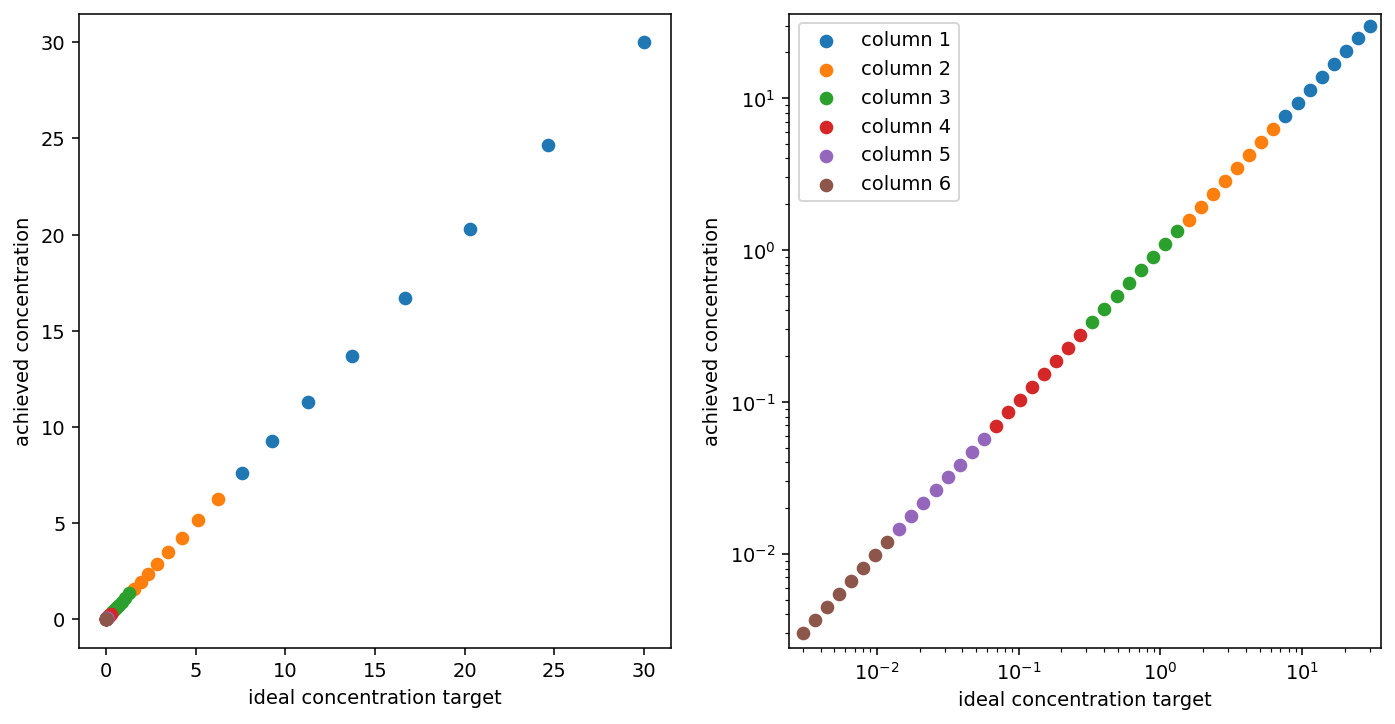

In [4]:
fig, (left, right) = pyplot.subplots(ncols=2, figsize=(12, 6), dpi=140)

for c in range(plan.C):
    x = plan.ideal_x[:,c]
    y = plan.x[:,c]
    left.scatter(x.flatten('F'), y.flatten('F'))
    right.scatter(x.flatten('F'), y.flatten('F'), label=f'column {c+1}')
right.set_xscale('log')
right.set_yscale('log')
right.set_xlim(plan.xmin*0.8, plan.xmax*1.2)
right.set_ylim(plan.xmin*0.8, plan.xmax*1.2)

left.set_xlabel('ideal concentration target')
left.set_ylabel('achieved concentration')
right.set_xlabel('ideal concentration target')
right.set_ylabel('achieved concentration')

right.legend()

pyplot.show()

In [5]:
max_relative_error = numpy.abs(1 - plan.x / plan.ideal_x).max()
print(f'The final concentrations deviate from the ideal concentrations by <= {max_relative_error*100:.1f} %')

The final concentrations deviate from the ideal concentrations by <= 1.8 %


## From `DilutionPlan` to `Worklist`
The instructions are also machine readable.
In the `DilutionPlan.instructions` attribute, you can find a list of tuples `(c, dsteps, src, v)`:
+ `c`: number of the column (0-based)
+ `dsteps`: number of serial dilution steps that were required to make the column
+ `src`: source to prepare the column from (either `'stock'` or 0-based column number)
+ `v`: transfer volumes for preparing the column
    
However you don't need to write the `Worklist` logic yourself, because there's already a method for that:

In [6]:
standard = robotools.Trough("Standard", 8, 1, min_volume=1000, max_volume=100_000, initial_volumes=100_000)
diluent = robotools.Trough("Diluent", 8, 1, min_volume=1000, max_volume=100_000, initial_volumes=100_000)

# A deep well plate to prepare the dilution series
dwp = robotools.Labware("DWP", 8, 12, min_volume=20, max_volume=2000)

# A microtiterplate to transfer to
mtp = robotools.Labware("MTP", 8, 12, min_volume=20, max_volume=2000)

with robotools.Worklist() as wl:
    plan.to_worklist(
        worklist=wl,
        stock=standard, stock_column=0,
        diluent=diluent, diluent_column=0,
        dilution_plate=dwp,
        destination_plate=mtp,
        v_destination=100
        # Watch out for the optional kwargs - there you'll have to specify
        # the liquid classes as they are configured on your Freedom EVO.
    )
    # TIP: If you want to insert custom operations such as transferring
    #      to multiple destinations or splitting into multiple worklists,
    #      take a look at the `pre_mix_hook` and `post_mix_hook` kwargs
    #      of the `DilutionPlan.to_worklist` method!
    
    # Place a second replicate in the right half
    wl.transfer(
        dwp, dwp.wells[:, :6],
        mtp, mtp.wells[:, 6:],
        volumes=100
    )

We can use the `composition` to access the final concentrations.
And don't forget to save them for later analysis!

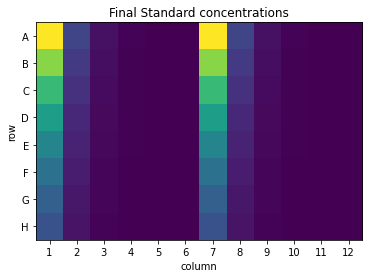

In [7]:
fig, ax = pyplot.subplots()
ax.imshow(mtp.composition["Standard"])
x = numpy.arange(12)
ax.set(
    yticks=numpy.arange(8), yticklabels="ABCDEFGH",
    xticks=x, xticklabels=map(str, x+1),
    ylabel="row", xlabel="column",
    title="Final Standard concentrations"
)
pyplot.show()